In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##code_without_execution_time

Using device: cuda

VISION TRANSFORMER TRAINING

LOADING MNIST DATA


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]


Loaded MNIST dataset
Training samples: 60000
Test samples: 10000

DATA CONFIGURATION
Detected image size: 32x32
Number of classes: 10

Training samples: 60000
Test samples: 10000
Calculated batch size: 600 (for 100 iterations/epoch)

MODEL INITIALIZATION
Total parameters: 5,689
Iterations per epoch: 100
Total iterations: 5000

TRAINING

Epoch 1/50:
  Train Loss: 1.9080
  Train Accuracy (overall): 56.05%
  Avg Accuracy per Iteration: 56.05%
  Test Accuracy: 75.88%
  Iterations: 100

Epoch 2/50:
  Train Loss: 1.6822
  Train Accuracy (overall): 78.14%
  Avg Accuracy per Iteration: 78.14%
  Test Accuracy: 81.06%
  Iterations: 100

Epoch 3/50:
  Train Loss: 1.6506
  Train Accuracy (overall): 81.15%
  Avg Accuracy per Iteration: 81.15%
  Test Accuracy: 81.23%
  Iterations: 100

Epoch 4/50:
  Train Loss: 1.6367
  Train Accuracy (overall): 82.45%
  Avg Accuracy per Iteration: 82.45%
  Test Accuracy: 82.31%
  Iterations: 100

Epoch 5/50:
  Train Loss: 1.6319
  Train Accuracy (overall): 82.92%
 

NameError: name 'data_loading_time' is not defined

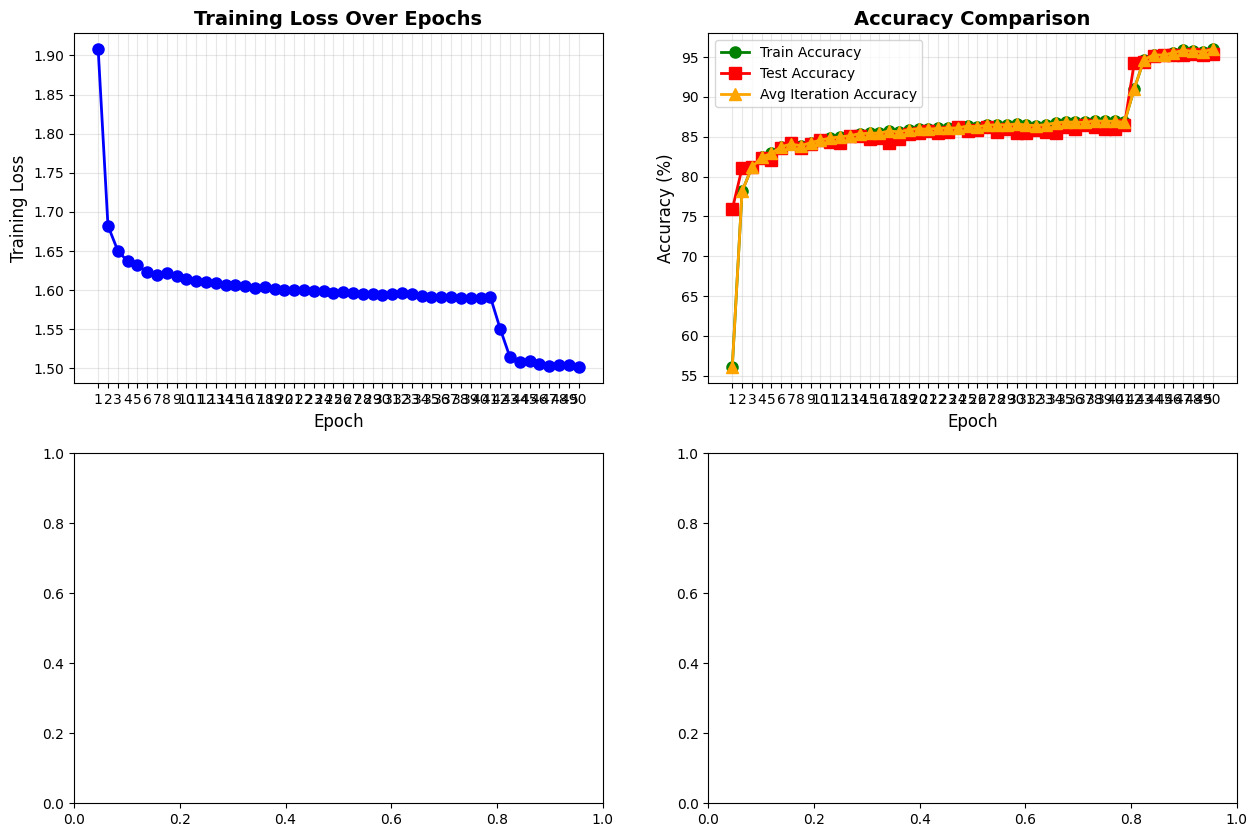

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# Hyperparameters
d_model = 9
n_classes = 10  # Will be auto-detected from data
img_size = (32, 32)  # Will be auto-detected from data
patch_size = (16, 16)
n_channels = 1
n_heads = 3
n_layers = 3
n_iterations_per_epoch = 100
epochs = 50
alpha = 0.005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Custom Dataset class for CSV files
class CSVImageDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

        print(f"\nLoading CSV: {csv_file}")
        print(f"CSV shape: {self.data.shape}")
        print(f"Columns: {self.data.columns.tolist()}")

        # Assuming first column is image, second is label
        self.labels = self.data.iloc[:, 1].values.astype(int)

        # Parse images from string format
        images_list = []
        first_row = str(self.data.iloc[0, 0])
        print(f"First row sample (200 chars): {first_row[:200]}")

        for idx in range(len(self.data)):
            img_str = str(self.data.iloc[idx, 0])

            try:
                # Try ast.literal_eval first
                img_array = np.array(ast.literal_eval(img_str))
                images_list.append(img_array)
            except:
                try:
                    # Try JSON
                    import json
                    img_array = np.array(json.loads(img_str))
                    images_list.append(img_array)
                except:
                    # Manual parsing
                    img_str_clean = img_str.replace('[', '').replace(']', '').replace('\n', ' ')
                    values = [int(x) for x in img_str_clean.split() if x.strip().isdigit()]
                    n_pixels = len(values)
                    img_size = int(np.sqrt(n_pixels))
                    img_array = np.array(values).reshape(img_size, img_size)
                    images_list.append(img_array)

            if (idx + 1) % 1000 == 0:
                print(f"Parsed {idx + 1}/{len(self.data)} images...")

        self.images = np.array(images_list)

        # Add channel dimension if needed
        if len(self.images.shape) == 3:
            self.images = self.images[:, np.newaxis, :, :]

        # Normalize
        if self.images.max() > 1:
            self.images = self.images.astype(np.float32) / 255.0
        else:
            self.images = self.images.astype(np.float32)

        self.image_size = self.images.shape[2]

        print(f"Successfully loaded {len(self.labels)} images")
        print(f"Image shape: {self.images.shape}")
        print(f"Image size: {self.image_size}x{self.image_size}")
        print(f"Label range: {self.labels.min()} to {self.labels.max()}")
        print(f"Pixel range: {self.images.min():.3f} to {self.images.max():.3f}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.FloatTensor(self.images[idx])
        label = int(self.labels[idx])
        return image, label

# Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.d_model = d_model
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.linear_project = nn.Conv2d(self.n_channels, self.d_model,
                                       kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        pe = torch.zeros(max_seq_length, d_model)
        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos/(10000 ** (i/d_model)))
                else:
                    pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/d_model)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)
        x = torch.cat((tokens_batch, x), dim=1)
        x = x + self.pe
        return x

# Attention Head
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = head_size
        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention = Q @ K.transpose(-2, -1)
        attention = attention / (self.head_size ** 0.5)
        attention = torch.softmax(attention, dim=-1)
        attention = attention @ V
        return attention

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.head_size = d_model // n_heads
        self.W_o = nn.Linear(d_model, d_model)
        self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.W_o(out)
        return out

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ln2 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        out = x + self.mha(self.ln1(x))
        out = out + self.mlp(self.ln2(out))
        return out

# Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_classes = n_classes
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.n_heads = n_heads

        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1

        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        self.classifier = nn.Sequential(
            nn.Linear(self.d_model, self.n_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x

# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Main execution
print("\n" + "="*60)
print("VISION TRANSFORMER TRAINING")
print("="*60)

# Configure data source
USE_CSV = False  # Set to True to use CSV files, False to use MNIST

if USE_CSV:
    # For CSV files - UPDATE THESE PATHS
    train_csv = '/content/emnist-balanced-test.csv'
    test_csv = '/content/emnist-balanced-test.csv'

    print("\n" + "="*60)
    print("LOADING DATA FROM CSV")
    print("="*60)

    train_dataset = CSVImageDataset(train_csv)
    test_dataset = CSVImageDataset(test_csv)
else:
    # Use MNIST dataset
    from torchvision.datasets.mnist import MNIST

    print("\n" + "="*60)
    print("LOADING MNIST DATA")
    print("="*60)

    transform = T.Compose([
        T.Resize(img_size),
        T.ToTensor()
    ])

    class MNISTWrapper(Dataset):
        def __init__(self, mnist_dataset):
            self.dataset = mnist_dataset
            self.labels = np.array([label for _, label in mnist_dataset])
            self.image_size = 32  # After resize

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return self.dataset[idx]

    mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)

    train_dataset = MNISTWrapper(mnist_train)
    test_dataset = MNISTWrapper(mnist_test)

    print(f"Loaded MNIST dataset")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

# Update configuration based on detected data
detected_img_size = train_dataset.image_size
n_classes = len(np.unique(train_dataset.labels))

print(f"\n" + "="*60)
print("DATA CONFIGURATION")
print("="*60)
print(f"Detected image size: {detected_img_size}x{detected_img_size}")
print(f"Number of classes: {n_classes}")

# Adjust patch size if needed
original_patch_size = patch_size[0]
for ps in [16, 14, 8, 7, 4, 2, 1]:
    if detected_img_size % ps == 0:
        patch_size = (ps, ps)
        if ps != original_patch_size:
            print(f"Adjusted patch size from {original_patch_size} to {ps}")
        break

img_size = (detected_img_size, detected_img_size)

# Calculate batch size for 200 iterations per epoch
train_dataset_size = len(train_dataset)
batch_size = train_dataset_size // n_iterations_per_epoch

print(f"\nTraining samples: {train_dataset_size}")
print(f"Test samples: {len(test_dataset)}")
print(f"Calculated batch size: {batch_size} (for {n_iterations_per_epoch} iterations/epoch)")

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

print(f"\n" + "="*60)
print("MODEL INITIALIZATION")
print("="*60)

# Initialize model
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size,
                               n_channels, n_heads, n_layers).to(device)
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

total_params = sum(p.numel() for p in transformer.parameters())
print(f"Total parameters: {total_params:,}")
print(f"Iterations per epoch: {len(train_loader)}")
print(f"Total iterations: {len(train_loader) * epochs}")

epoch_train_losses = []
epoch_train_accuracies = []
epoch_test_accuracies = []
epoch_avg_iteration_accuracies = []

print(f"\n" + "="*60)
print("TRAINING")
print("="*60)

# Train for 5 epochs
for epoch in range(epochs):
    transformer.train()
    training_loss = 0.0
    correct_train = 0
    total_train = 0

    # Track accuracy per iteration
    iteration_accuracies = []

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Calculate batch accuracy
        batch_correct = (predicted == labels).sum().item()
        batch_accuracy = 100 * batch_correct / labels.size(0)
        iteration_accuracies.append(batch_accuracy)

    # Calculate epoch metrics
    avg_train_loss = training_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    test_accuracy = evaluate(transformer, test_loader, device)
    avg_iteration_accuracy = np.mean(iteration_accuracies)

    epoch_train_losses.append(avg_train_loss)
    epoch_train_accuracies.append(train_accuracy)
    epoch_test_accuracies.append(test_accuracy)
    epoch_avg_iteration_accuracies.append(avg_iteration_accuracy)

    print(f"\nEpoch {epoch + 1}/{epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Train Accuracy (overall): {train_accuracy:.2f}%")
    print(f"  Avg Accuracy per Iteration: {avg_iteration_accuracy:.2f}%")
    print(f"  Test Accuracy: {test_accuracy:.2f}%")
    print(f"  Iterations: {len(train_loader)}")

# Calculate averages
avg_test_accuracy = np.mean(epoch_test_accuracies)
avg_iteration_accuracy_overall = np.mean(epoch_avg_iteration_accuracies)

print(f"\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Average Test Accuracy (across {epochs} epochs): {avg_test_accuracy:.2f}%")
print(f"Average Iteration Accuracy (overall): {avg_iteration_accuracy_overall:.2f}%")
print(f"Final Test Accuracy (epoch {epochs}): {epoch_test_accuracies[-1]:.2f}%")

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, epochs + 1)

# Plot 1: Training Loss
axes[0, 0].plot(epochs_range, epoch_train_losses, marker='o', linewidth=2, markersize=8, color='blue')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Training Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(epochs_range)

# Plot 2: Train vs Test Accuracy
axes[0, 1].plot(epochs_range, epoch_train_accuracies, marker='o', linewidth=2, markersize=8,
                color='green', label='Train Accuracy')
axes[0, 1].plot(epochs_range, epoch_test_accuracies, marker='s', linewidth=2, markersize=8,
                color='red', label='Test Accuracy')
axes[0, 1].plot(epochs_range, epoch_avg_iteration_accuracies, marker='^', linewidth=2, markersize=8,
                color='orange', label='Avg Iteration Accuracy')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(epochs_range)

time_breakdown = [data_loading_time, model_init_time, training_time]
labels_breakdown = ['Data Loading', 'Model Init', 'Training']
colors_breakdown = ['#FF9999', '#9999CC', '#99FF99']
explode = (0.05, 0.05, 0)

wedges, texts, autotexts = axes[4].pie(time_breakdown, labels=labels_breakdown, autopct='%1.1f%%',
                                        colors=colors_breakdown, explode=explode, startangle=90,
                                        textprops={'fontsize': 11, 'weight': 'bold'},
                                        wedgeprops={'edgecolor': 'gray', 'linewidth': 2})
axes[4].set_title('Execution Time Breakdown', fontsize=14, fontweight='bold')

# Plot 3: Test Accuracy per Epoch
bars = axes[1, 0].bar(epochs_range, epoch_test_accuracies, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[1, 0].set_title('Test Accuracy per Epoch', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 100])
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_xticks(epochs_range)

for i, (bar, val) in enumerate(zip(bars, epoch_test_accuracies)):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}%',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: Summary Table
axes[1, 1].axis('off')
summary_data = [
    ['Epoch', 'Loss', 'Train Acc', 'Avg Iter Acc', 'Test Acc'],
    *[[f'{i+1}', f'{epoch_train_losses[i]:.3f}',
       f'{epoch_train_accuracies[i]:.1f}%',
       f'{epoch_avg_iteration_accuracies[i]:.1f}%',
       f'{epoch_test_accuracies[i]:.1f}%']
      for i in range(epochs)],
    ['', '', '', '', ''],
    ['Avg', '', '', f'{avg_iteration_accuracy_overall:.1f}%', f'{avg_test_accuracy:.1f}%']
]

table = axes[1, 1].table(cellText=summary_data, cellLoc='center', loc='center',
                         colWidths=[0.12, 0.18, 0.18, 0.24, 0.18])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

for i in range(5):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(5):
    table[(epochs + 2, i)].set_facecolor('#E7E6E6')
    table[(epochs + 2, i)].set_text_props(weight='bold')

axes[1, 1].set_title('Training Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('vit_csv_training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved as 'vit_csv_training_results.png'")

#old code

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import time
import os

# Hyperparameters
d_model = 9
n_classes = 10  # Will be auto-detected from data
img_size = (32, 32)  # Will be auto-detected from data
patch_size = (16, 16)
n_channels = 1
n_heads = 3
n_layers = 3
n_iterations_per_epoch = 100
epochs = 50
alpha = 0.005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Custom Dataset class for CSV files
class CSVImageDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

        print(f"\nLoading CSV: {csv_file}")
        print(f"CSV shape: {self.data.shape}")
        print(f"Columns: {self.data.columns.tolist()}")

        # Assuming first column is image, second is label
        self.labels = self.data.iloc[:, 1].values.astype(int)

        # Parse images from string format
        images_list = []
        first_row = str(self.data.iloc[0, 0])
        print(f"First row sample (200 chars): {first_row[:200]}")

        for idx in range(len(self.data)):
            img_str = str(self.data.iloc[idx, 0])

            try:
                # Try ast.literal_eval first
                img_array = np.array(ast.literal_eval(img_str))
                images_list.append(img_array)
            except:
                try:
                    # Try JSON
                    import json
                    img_array = np.array(json.loads(img_str))
                    images_list.append(img_array)
                except:
                    # Manual parsing
                    img_str_clean = img_str.replace('[', '').replace(']', '').replace('\n', ' ')
                    values = [int(x) for x in img_str_clean.split() if x.strip().isdigit()]
                    n_pixels = len(values)
                    img_size = int(np.sqrt(n_pixels))
                    img_array = np.array(values).reshape(img_size, img_size)
                    images_list.append(img_array)

            if (idx + 1) % 1000 == 0:
                print(f"Parsed {idx + 1}/{len(self.data)} images...")

        self.images = np.array(images_list)

        # Add channel dimension if needed
        if len(self.images.shape) == 3:
            self.images = self.images[:, np.newaxis, :, :]

        # Normalize
        if self.images.max() > 1:
            self.images = self.images.astype(np.float32) / 255.0
        else:
            self.images = self.images.astype(np.float32)

        self.image_size = self.images.shape[2]

        print(f"Successfully loaded {len(self.labels)} images")
        print(f"Image shape: {self.images.shape}")
        print(f"Image size: {self.image_size}x{self.image_size}")
        print(f"Label range: {self.labels.min()} to {self.labels.max()}")
        print(f"Pixel range: {self.images.min():.3f} to {self.images.max():.3f}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.FloatTensor(self.images[idx])
        label = int(self.labels[idx])
        return image, label

# Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.d_model = d_model
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.linear_project = nn.Conv2d(self.n_channels, self.d_model,
                                       kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        pe = torch.zeros(max_seq_length, d_model)
        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos/(10000 ** (i/d_model)))
                else:
                    pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/d_model)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)
        x = torch.cat((tokens_batch, x), dim=1)
        x = x + self.pe
        return x

# Attention Head
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = d_model // n_heads
        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention = Q @ K.transpose(-2, -1)
        attention = attention / (self.head_size ** 0.5)
        attention = torch.softmax(attention, dim=-1)
        attention = attention @ V
        return attention

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.head_size = d_model // n_heads
        self.W_o = nn.Linear(d_model, d_model)
        self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.W_o(out)
        return out

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ln2 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        out = x + self.mha(self.ln1(x))
        out = out + self.mlp(self.ln2(out))
        return out

# Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_classes = n_classes
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.n_heads = n_heads

        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1

        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        self.classifier = nn.Sequential(
            nn.Linear(self.d_model, self.n_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x

# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Main execution
print("\n" + "="*60)
print("VISION TRANSFORMER TRAINING")
print("="*60)

# Track total execution time
start_total = time.time()

# Configure data source
USE_CSV = False  # Set to True to use CSV files, False to use MNIST

if USE_CSV:
    # For CSV files - UPDATE THESE PATHS
    train_csv = '/content/emnist-balanced-train.csv'
    test_csv = '/content/emnist-balanced-test.csv'

    print("\n" + "="*60)
    print("LOADING DATA FROM CSV")
    print("="*60)

    train_dataset = CSVImageDataset(train_csv)
    test_dataset = CSVImageDataset(test_csv)
else:
    # Use MNIST dataset
    from torchvision.datasets.mnist import MNIST
    import os

    print("\n" + "="*60)
    print("LOADING MNIST DATA")
    print("="*60)

    transform = T.Compose([
        T.Resize(img_size),
        T.ToTensor()
    ])

    class MNISTWrapper(Dataset):
        def __init__(self, mnist_dataset):
            self.dataset = mnist_dataset
            self.labels = np.array([label for _, label in mnist_dataset])
            self.image_size = 32  # After resize

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return self.dataset[idx]

    # Provide a directory for MNIST data
    mnist_root_dir = '/content/mnist_data'
    os.makedirs(mnist_root_dir, exist_ok=True) # Create directory if it doesn't exist

    mnist_train = MNIST(root=mnist_root_dir, train=True, download=True, transform=transform)
    mnist_test = MNIST(root=mnist_root_dir, train=False, download=True, transform=transform)

    train_dataset = MNISTWrapper(mnist_train)
    test_dataset = MNISTWrapper(mnist_test)

    print(f"Loaded MNIST dataset")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

end_data_loading = time.time()
data_loading_time = end_data_loading - start_total

# Update configuration based on detected data
detected_img_size = train_dataset.image_size
n_classes = len(np.unique(train_dataset.labels))

print(f"\n" + "="*60)
print("DATA CONFIGURATION")
print("="*60)
print(f"Detected image size: {detected_img_size}x{detected_img_size}")
print(f"Number of classes: {n_classes}")

# Adjust patch size if needed
original_patch_size = patch_size[0]
for ps in [16, 14, 8, 7, 4, 2, 1]:
    if detected_img_size % ps == 0:
        patch_size = (ps, ps)
        if ps != original_patch_size:
            print(f"Adjusted patch size from {original_patch_size} to {ps}")
        break

img_size = (detected_img_size, detected_img_size)

# Calculate batch size for 200 iterations per epoch
train_dataset_size = len(train_dataset)
batch_size = train_dataset_size // n_iterations_per_epoch

print(f"\nTraining samples: {train_dataset_size}")
print(f"Test samples: {len(test_dataset)}")
print(f"Calculated batch size: {batch_size} (for {n_iterations_per_epoch} iterations/epoch)")

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

print(f"\n" + "="*60)
print("MODEL INITIALIZATION")
print("="*60)

# Initialize model
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size,
                               n_channels, n_heads, n_layers).to(device)
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

total_params = sum(p.numel() for p in transformer.parameters())
print(f"Total parameters: {total_params:,}")
print(f"Iterations per epoch: {len(train_loader)}")
print(f"Total iterations: {len(train_loader) * epochs}")

end_model_init = time.time()
model_init_time = end_model_init - end_data_loading

epoch_train_losses = []
epoch_train_accuracies = []
epoch_test_accuracies = []
epoch_avg_iteration_accuracies = []
epoch_times = []

print(f"\n" + "="*60)
print("TRAINING")
print("="*60)

start_training = time.time()

# Train for 5 epochs
for epoch in range(epochs):
    epoch_start = time.time()
    transformer.train()
    training_loss = 0.0
    correct_train = 0
    total_train = 0

    # Track accuracy per iteration
    iteration_accuracies = []

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Calculate batch accuracy
        batch_correct = (predicted == labels).sum().item()
        batch_accuracy = 100 * batch_correct / labels.size(0)
        iteration_accuracies.append(batch_accuracy)

    # Calculate epoch metrics
    avg_train_loss = training_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    test_accuracy = evaluate(transformer, test_loader, device)
    avg_iteration_accuracy = np.mean(iteration_accuracies)

    epoch_train_losses.append(avg_train_loss)
    epoch_train_accuracies.append(train_accuracy)
    epoch_test_accuracies.append(test_accuracy)
    epoch_avg_iteration_accuracies.append(avg_iteration_accuracy)

    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start
    epoch_times.append(epoch_duration)

    print(f"\nEpoch {epoch + 1}/{epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Train Accuracy (overall): {train_accuracy:.2f}%")
    print(f"  Avg Accuracy per Iteration: {avg_iteration_accuracy:.2f}%")
    print(f"  Test Accuracy: {test_accuracy:.2f}%")
    print(f"  Epoch Time: {epoch_duration:.2f} seconds")

# Calculate averages
end_training = time.time()
training_time = end_training - start_training
total_execution_time = end_training - start_total

avg_test_accuracy = np.mean(epoch_test_accuracies)
avg_iteration_accuracy_overall = np.mean(epoch_avg_iteration_accuracies)

print(f"\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Average Test Accuracy (across {epochs} epochs): {avg_test_accuracy:.2f}%")
print(f"Average Iteration Accuracy (overall): {avg_iteration_accuracy_overall:.2f}%")
print(f"Final Test Accuracy (epoch {epochs}): {epoch_test_accuracies[-1]:.2f}%")
print(f"\nExecution Time Breakdown:")
print(f"  Data Loading: {data_loading_time:.2f}s ({100*data_loading_time/total_execution_time:.1f}%)")
print(f"  Model Init: {model_init_time:.2f}s ({100*model_init_time/total_execution_time:.1f}%)")
print(f"  Training: {training_time:.2f}s ({100*training_time/total_execution_time:.1f}%)")
print(f"  Total: {total_execution_time:.2f}s")

# Plot results
fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(4, 2, hspace=0.4, wspace=0.4)

# Explicitly create subplots and assign to variables
ax1 = fig.add_subplot(gs[0, 0])  # Training Loss
ax2 = fig.add_subplot(gs[0, 1])  # Train vs Test Accuracy
ax3 = fig.add_subplot(gs[1, 0])  # Training Time per Epoch
ax4 = fig.add_subplot(gs[1, 1])  # Test Accuracy per Epoch
ax5 = fig.add_subplot(gs[2, 0])  # Execution Time Breakdown
ax6 = fig.add_subplot(gs[2:, 1])   # Summary Table in a larger area, spans rows 2 and 3 of column 1

# Populate axes list in the correct order
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

epochs_range = range(1, epochs + 1)

# Plot 1: Training Loss
axes[0].plot(epochs_range, epoch_train_losses, marker='o', linewidth=2, markersize=8, color='blue')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(epochs_range)

# Plot 2: Train vs Test Accuracy
axes[1].plot(epochs_range, epoch_train_accuracies, marker='o', linewidth=2, markersize=8,
                color='green', label='Train Accuracy')
axes[1].plot(epochs_range, epoch_test_accuracies, marker='s', linewidth=2, markersize=8,
                color='red', label='Test Accuracy')
axes[1].plot(epochs_range, epoch_avg_iteration_accuracies, marker='^', linewidth=2, markersize=8,
                color='orange', label='Avg Iteration Accuracy')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(epochs_range)

# Plot 3: Training Time per Epoch
axes[2].plot(epochs_range, epoch_times, marker='o', linewidth=2.5, markersize=10,
             color='purple', markerfacecolor='purple', markeredgewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Time (seconds)', fontsize=12)
axes[2].set_title('Training Time per Epoch', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(epochs_range)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# Plot 4: Test Accuracy per Epoch
bars = axes[3].bar(epochs_range, epoch_test_accuracies, color='steelblue', alpha=0.7, edgecolor='black')
axes[3].set_xlabel('Epoch', fontsize=12)
axes[3].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[3].set_title('Test Accuracy per Epoch', fontsize=14, fontweight='bold')
axes[3].set_ylim([0, 100])
axes[3].grid(True, alpha=0.3, axis='y')
axes[3].set_xticks(epochs_range)

for i, (bar, val) in enumerate(zip(bars, epoch_test_accuracies)):
    axes[3].text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}%',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 5: Execution Time Breakdown
time_breakdown = [data_loading_time, model_init_time, training_time]
labels_breakdown = ['Data Loading', 'Model Init', 'Training']
colors_breakdown = ['#FF9999', '#9999CC', '#99FF99']
explode = (0.05, 0.05, 0)

wedges, texts, autotexts = axes[4].pie(time_breakdown, labels=labels_breakdown, autopct='%1.1f%%',
                                        colors=colors_breakdown, explode=explode, startangle=90,
                                        textprops={'fontsize': 11, 'weight': 'bold'},
                                        wedgeprops={'edgecolor': 'gray', 'linewidth': 2})
axes[4].set_title('Execution Time Breakdown', fontsize=14, fontweight='bold')

# Make percentage text larger and bold
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')

# Plot 6: Summary Table
axes[5].axis('off')
summary_data = [
    ['Epoch', 'Loss', 'Train Acc', 'Avg Iter Acc', 'Test Acc', 'Time (s)'],
    *[[f'{i+1}', f'{epoch_train_losses[i]:.3f}',
       f'{epoch_train_accuracies[i]:.1f}%',
       f'{epoch_avg_iteration_accuracies[i]:.1f}%',
       f'{epoch_test_accuracies[i]:.1f}%',
       f'{epoch_times[i]:.2f}']
      for i in range(epochs)],
    ['', '', '', '', '', ''],
    ['Avg', '', '', f'{avg_iteration_accuracy_overall:.1f}%', f'{avg_test_accuracy:.1f}%', f'{np.mean(epoch_times):.2f}']
]

table = axes[5].table(cellText=summary_data, cellLoc='center', loc='center',
                         colWidths=[0.10, 0.15, 0.15, 0.20, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

for i in range(6):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(6):
    table[(epochs + 2, i)].set_facecolor('#E7E6E6')
    table[(epochs + 2, i)].set_text_props(weight='bold')

axes[5].set_title('Training Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('vit_csv_training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved as 'vit_csv_training_results.png'")

##code_with_execution_time

Using device: cuda

VISION TRANSFORMER TRAINING

LOADING MNIST DATA


100%|██████████| 9.91M/9.91M [00:00<00:00, 63.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.45MB/s]


Loaded MNIST dataset
Training samples: 60000
Test samples: 10000

DATA CONFIGURATION
Detected image size: 32x32
Number of classes: 10

Training samples: 60000
Test samples: 10000
Calculated batch size: 600 (for 100 iterations/epoch)

MODEL INITIALIZATION
Total parameters: 5,689
Iterations per epoch: 100
Total iterations: 5000

TRAINING
Epoch 10/50: Train Loss: 1.5285, Train Acc: 93.30%, Test Acc: 93.37%, Time: 11.24s
Epoch 20/50: Train Loss: 1.5160, Train Acc: 94.51%, Test Acc: 94.81%, Time: 11.21s
Epoch 30/50: Train Loss: 1.5082, Train Acc: 95.30%, Test Acc: 95.03%, Time: 10.84s
Epoch 40/50: Train Loss: 1.5049, Train Acc: 95.64%, Test Acc: 95.15%, Time: 11.16s
Epoch 50/50: Train Loss: 1.5003, Train Acc: 96.09%, Test Acc: 95.50%, Time: 10.97s

TRAINING COMPLETE
Average Train Accuracy: 93.62%
Average Test Accuracy: 93.68%
Final Test Accuracy: 95.50%

Execution Time Summary:
  Data Loading: 10.52 seconds
  Model Init: 0.32 seconds
  Total Training: 566.59 seconds
  Average Time per Epoch

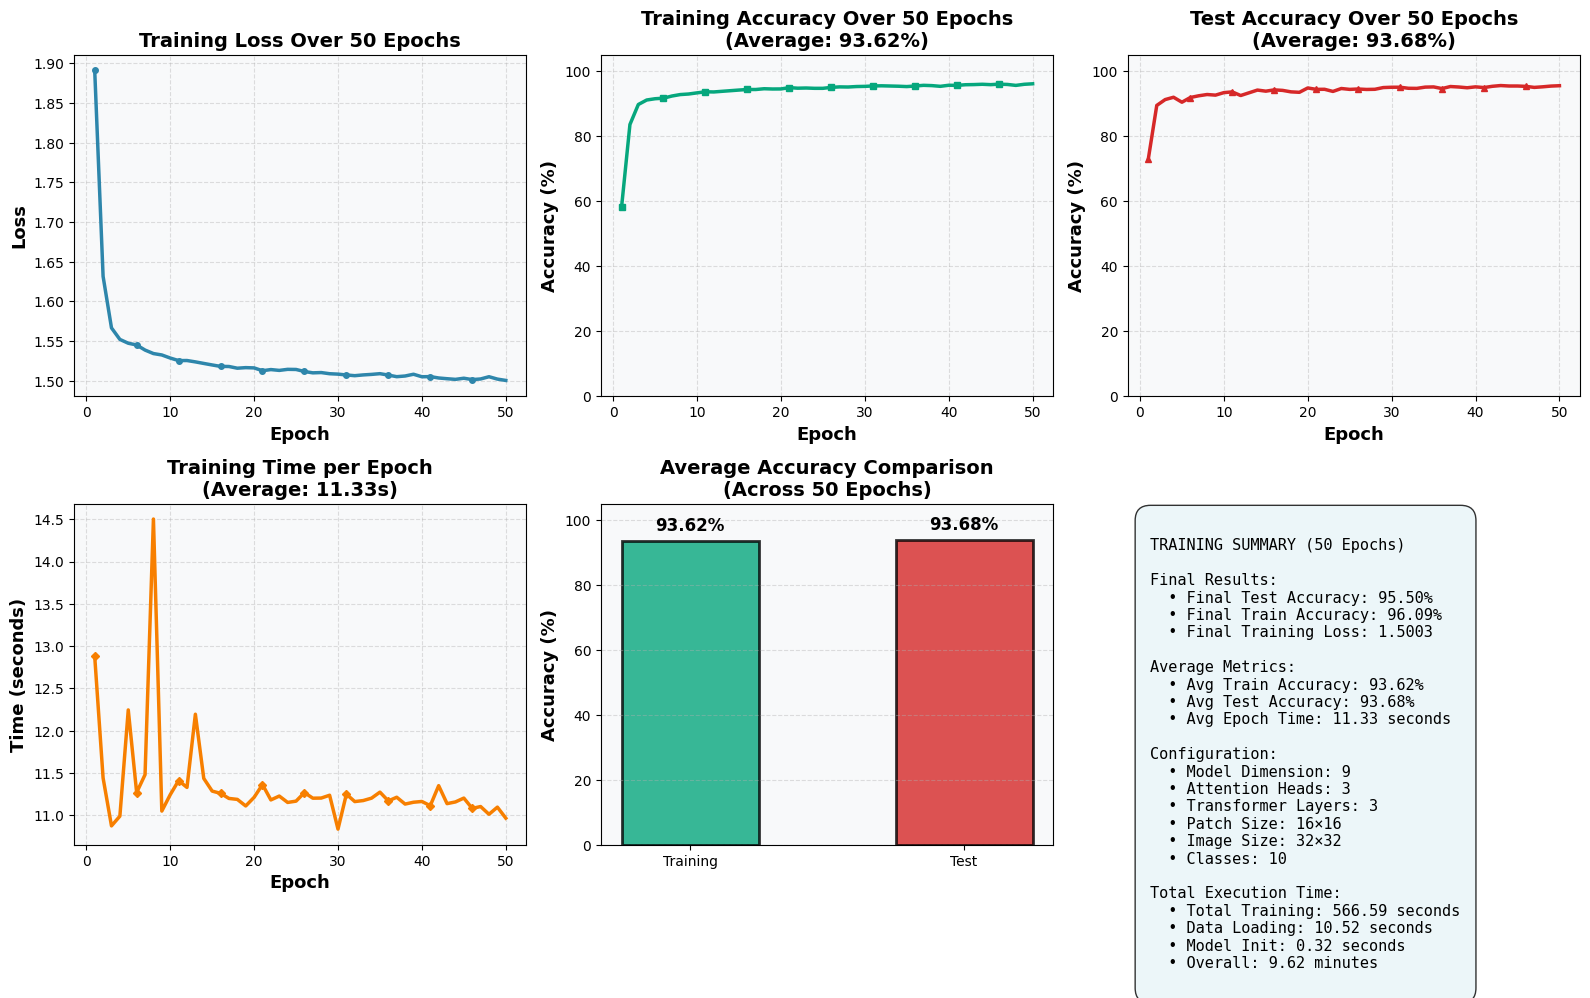


Plot saved as 'vit_csv_training_results_clear.png'


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import time
import os

# Hyperparameters
d_model = 9
n_classes = 10
img_size = (32, 32)
patch_size = (16, 16)
n_channels = 1
n_heads = 3
n_layers = 3
n_iterations_per_epoch = 100
epochs = 50
alpha = 0.005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Custom Dataset class for CSV files
class CSVImageDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

        print(f"\nLoading CSV: {csv_file}")
        print(f"CSV shape: {self.data.shape}")
        print(f"Columns: {self.data.columns.tolist()}")

        # Assuming first column is image, second is label
        self.labels = self.data.iloc[:, 1].values.astype(int)

        # Parse images from string format
        images_list = []
        first_row = str(self.data.iloc[0, 0])
        print(f"First row sample (200 chars): {first_row[:200]}")

        for idx in range(len(self.data)):
            img_str = str(self.data.iloc[idx, 0])

            try:
                img_array = np.array(ast.literal_eval(img_str))
                images_list.append(img_array)
            except:
                try:
                    import json
                    img_array = np.array(json.loads(img_str))
                    images_list.append(img_array)
                except:
                    img_str_clean = img_str.replace('[', '').replace(']', '').replace('\n', ' ')
                    values = [int(x) for x in img_str_clean.split() if x.strip().isdigit()]
                    n_pixels = len(values)
                    img_size = int(np.sqrt(n_pixels))
                    img_array = np.array(values).reshape(img_size, img_size)
                    images_list.append(img_array)

            if (idx + 1) % 1000 == 0:
                print(f"Parsed {idx + 1}/{len(self.data)} images...")

        self.images = np.array(images_list)

        if len(self.images.shape) == 3:
            self.images = self.images[:, np.newaxis, :, :]

        if self.images.max() > 1:
            self.images = self.images.astype(np.float32) / 255.0
        else:
            self.images = self.images.astype(np.float32)

        self.image_size = self.images.shape[2]

        print(f"Successfully loaded {len(self.labels)} images")
        print(f"Image shape: {self.images.shape}")
        print(f"Image size: {self.image_size}x{self.image_size}")
        print(f"Label range: {self.labels.min()} to {self.labels.max()}")
        print(f"Pixel range: {self.images.min():.3f} to {self.images.max():.3f}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.FloatTensor(self.images[idx])
        label = int(self.labels[idx])
        return image, label

# Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.d_model = d_model
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.linear_project = nn.Conv2d(self.n_channels, self.d_model,
                                       kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        pe = torch.zeros(max_seq_length, d_model)
        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos/(10000 ** (i/d_model)))
                else:
                    pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/d_model)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)
        x = torch.cat((tokens_batch, x), dim=1)
        x = x + self.pe
        return x

# Attention Head
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = head_size
        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention = Q @ K.transpose(-2, -1)
        attention = attention / (self.head_size ** 0.5)
        attention = torch.softmax(attention, dim=-1)
        attention = attention @ V
        return attention

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.head_size = d_model // n_heads
        self.W_o = nn.Linear(d_model, d_model)
        self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.W_o(out)
        return out

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ln2 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        out = x + self.mha(self.ln1(x))
        out = out + self.mlp(self.ln2(out))
        return out

# Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_classes = n_classes
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.n_heads = n_heads

        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1

        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        self.classifier = nn.Sequential(
            nn.Linear(self.d_model, self.n_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x

# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Main execution
print("\n" + "="*60)
print("VISION TRANSFORMER TRAINING")
print("="*60)

start_total = time.time()

# Configure data source
USE_CSV = False

if USE_CSV:
    train_csv = '/content/emnist-balanced-train.csv'
    test_csv = '/content/emnist-balanced-test.csv'

    print("\n" + "="*60)
    print("LOADING DATA FROM CSV")
    print("="*60)

    train_dataset = CSVImageDataset(train_csv)
    test_dataset = CSVImageDataset(test_csv)
else:
    from torchvision.datasets.mnist import MNIST

    print("\n" + "="*60)
    print("LOADING MNIST DATA")
    print("="*60)

    transform = T.Compose([
        T.Resize(img_size),
        T.ToTensor()
    ])

    class MNISTWrapper(Dataset):
        def __init__(self, mnist_dataset):
            self.dataset = mnist_dataset
            self.labels = np.array([label for _, label in mnist_dataset])
            self.image_size = 32

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return self.dataset[idx]

    mnist_root_dir = '/content/mnist_data'
    os.makedirs(mnist_root_dir, exist_ok=True)

    mnist_train = MNIST(root=mnist_root_dir, train=True, download=True, transform=transform)
    mnist_test = MNIST(root=mnist_root_dir, train=False, download=True, transform=transform)

    train_dataset = MNISTWrapper(mnist_train)
    test_dataset = MNISTWrapper(mnist_test)

    print(f"Loaded MNIST dataset")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

end_data_loading = time.time()
data_loading_time = end_data_loading - start_total

detected_img_size = train_dataset.image_size
n_classes = len(np.unique(train_dataset.labels))

print(f"\n" + "="*60)
print("DATA CONFIGURATION")
print("="*60)
print(f"Detected image size: {detected_img_size}x{detected_img_size}")
print(f"Number of classes: {n_classes}")

original_patch_size = patch_size[0]
for ps in [16, 14, 8, 7, 4, 2, 1]:
    if detected_img_size % ps == 0:
        patch_size = (ps, ps)
        if ps != original_patch_size:
            print(f"Adjusted patch size from {original_patch_size} to {ps}")
        break

img_size = (detected_img_size, detected_img_size)

train_dataset_size = len(train_dataset)
batch_size = train_dataset_size // n_iterations_per_epoch

print(f"\nTraining samples: {train_dataset_size}")
print(f"Test samples: {len(test_dataset)}")
print(f"Calculated batch size: {batch_size} (for {n_iterations_per_epoch} iterations/epoch)")

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

print(f"\n" + "="*60)
print("MODEL INITIALIZATION")
print("="*60)

transformer = VisionTransformer(d_model, n_classes, img_size, patch_size,
                               n_channels, n_heads, n_layers).to(device)
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

total_params = sum(p.numel() for p in transformer.parameters())
print(f"Total parameters: {total_params:,}")
print(f"Iterations per epoch: {len(train_loader)}")
print(f"Total iterations: {len(train_loader) * epochs}")

end_model_init = time.time()
model_init_time = end_model_init - end_data_loading

epoch_train_losses = []
epoch_train_accuracies = []
epoch_test_accuracies = []
epoch_times = []

print(f"\n" + "="*60)
print("TRAINING")
print("="*60)

start_training = time.time()

for epoch in range(epochs):
    epoch_start = time.time()
    transformer.train()
    training_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = training_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    test_accuracy = evaluate(transformer, test_loader, device)

    epoch_train_losses.append(avg_train_loss)
    epoch_train_accuracies.append(train_accuracy)
    epoch_test_accuracies.append(test_accuracy)

    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start
    epoch_times.append(epoch_duration)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%, Time: {epoch_duration:.2f}s")

end_training = time.time()
training_time = end_training - start_training
total_execution_time = end_training - start_total

avg_test_accuracy = np.mean(epoch_test_accuracies)
avg_train_accuracy = np.mean(epoch_train_accuracies)
avg_epoch_time = np.mean(epoch_times)

print(f"\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Average Train Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Test Accuracy: {avg_test_accuracy:.2f}%")
print(f"Final Test Accuracy: {epoch_test_accuracies[-1]:.2f}%")
print(f"\nExecution Time Summary:")
print(f"  Data Loading: {data_loading_time:.2f} seconds")
print(f"  Model Init: {model_init_time:.2f} seconds")
print(f"  Total Training: {training_time:.2f} seconds")
print(f"  Average Time per Epoch: {avg_epoch_time:.2f} seconds")
print(f"  Total Execution Time: {total_execution_time/60:.2f} minutes")

# Clear and simple plots
fig = plt.figure(figsize=(16, 10))

epochs_range = range(1, epochs + 1)

# Plot 1: Training Loss
ax1 = plt.subplot(2, 3, 1)
ax1.plot(epochs_range, epoch_train_losses, linewidth=2.5, color='#2E86AB', marker='o', markersize=4, markevery=5)
ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax1.set_title('Training Loss Over 50 Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.4, linestyle='--')
ax1.set_facecolor('#F8F9FA')

# Plot 2: Training Accuracy
ax2 = plt.subplot(2, 3, 2)
ax2.plot(epochs_range, epoch_train_accuracies, linewidth=2.5, color='#06A77D', marker='s', markersize=4, markevery=5)
ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax2.set_title(f'Training Accuracy Over 50 Epochs\n(Average: {avg_train_accuracy:.2f}%)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.4, linestyle='--')
ax2.set_facecolor('#F8F9FA')
ax2.set_ylim([0, 105])

# Plot 3: Test Accuracy
ax3 = plt.subplot(2, 3, 3)
ax3.plot(epochs_range, epoch_test_accuracies, linewidth=2.5, color='#D62828', marker='^', markersize=4, markevery=5)
ax3.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax3.set_title(f'Test Accuracy Over 50 Epochs\n(Average: {avg_test_accuracy:.2f}%)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.4, linestyle='--')
ax3.set_facecolor('#F8F9FA')
ax3.set_ylim([0, 105])

# Plot 4: Time per Epoch
ax4 = plt.subplot(2, 3, 4)
ax4.plot(epochs_range, epoch_times, linewidth=2.5, color='#F77F00', marker='D', markersize=4, markevery=5)
ax4.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax4.set_ylabel('Time (seconds)', fontsize=13, fontweight='bold')
ax4.set_title(f'Training Time per Epoch\n(Average: {avg_epoch_time:.2f}s)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.4, linestyle='--')
ax4.set_facecolor('#F8F9FA')

# Plot 5: Train vs Test Comparison (Averaged)
ax5 = plt.subplot(2, 3, 5)
categories = ['Training', 'Test']
averages = [avg_train_accuracy, avg_test_accuracy]
colors_bar = ['#06A77D', '#D62828']
bars = ax5.bar(categories, averages, width=0.5, color=colors_bar, edgecolor='black', linewidth=2, alpha=0.8)
ax5.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax5.set_title('Average Accuracy Comparison\n(Across 50 Epochs)', fontsize=14, fontweight='bold')
ax5.set_ylim([0, 105])
ax5.grid(True, alpha=0.4, axis='y', linestyle='--')
ax5.set_facecolor('#F8F9FA')

for bar, val in zip(bars, averages):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{val:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 6: Summary Statistics
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

summary_text = f"""
TRAINING SUMMARY (50 Epochs)

Final Results:
  • Final Test Accuracy: {epoch_test_accuracies[-1]:.2f}%
  • Final Train Accuracy: {epoch_train_accuracies[-1]:.2f}%
  • Final Training Loss: {epoch_train_losses[-1]:.4f}

Average Metrics:
  • Avg Train Accuracy: {avg_train_accuracy:.2f}%
  • Avg Test Accuracy: {avg_test_accuracy:.2f}%
  • Avg Epoch Time: {avg_epoch_time:.2f} seconds

Configuration:
  • Model Dimension: {d_model}
  • Attention Heads: {n_heads}
  • Transformer Layers: {n_layers}
  • Patch Size: {patch_size[0]}×{patch_size[1]}
  • Image Size: {img_size[0]}×{img_size[1]}
  • Classes: {n_classes}

Total Execution Time:
  • Total Training: {training_time:.2f} seconds
  • Data Loading: {data_loading_time:.2f} seconds
  • Model Init: {model_init_time:.2f} seconds
  • Overall: {total_execution_time/60:.2f} minutes
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='#E8F4F8', alpha=0.8, pad=1))

plt.tight_layout()
plt.savefig('vit_csv_training_results_clear.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nPlot saved as 'vit_csv_training_results_clear.png'")